In [1]:
import findspark
findspark.init()

In [52]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc, desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

pd.options.display.max_columns=None
pd.options.display.max_rows=None

%matplotlib inline

spark=SparkSession.builder \
.master ("local[*]")\
.appName("MiniProject2")\
.getOrCreate()

In [3]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("../data/XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.")

There are 41188 rows 21 columns in the data.


In [53]:
df.show(4)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [6]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



## Renaming Columns
#### Column names are not setup for analysis. The period within each name causes issues when selecting. Altering columns names to avoid errors.

In [7]:
# renamed columns 
df2 = df.withColumnRenamed("cons.price.idx","cons_price_idx")\
.withColumnRenamed("emp.var.rate", "emp_var_rate")\
.withColumnRenamed("cons.conf.idx","cons_conf_idx")\
.withColumnRenamed("nr.employed", "nr_employed")

## Numeric Features 
### Summary Statistics

In [8]:
numeric_features = [t[0] for t in df2.dtypes if t[1] != 'string' ]
df2.select(numeric_features).summary().toPandas().set_index('summary').transpose()

summary,count,mean,stddev,min,25%,50%,75%,max
age,41188,40.02406040594348,10.421249980934043,17,32,38,47,98
duration,41188,258.2850101971448,259.27924883646455,0,102,180,319,4918
campaign,41188,2.567592502670681,2.770013542902331,1,1,2,3,56
pdays,41188,962.4754540157328,186.910907344741,0,999,999,999,999
previous,41188,0.17296299893172767,0.49490107983928927,0,0,0,0,7
emp_var_rate,41188,0.08188550063178966,1.57095974051703,-3.4,-1.8,1.1,1.4,1.4
cons_price_idx,41188,93.5756643682899,0.5788400489540823,92.201,93.075,93.749,93.994,94.767
cons_conf_idx,41188,-40.502600271918276,4.628197856174573,-50.8,-42.7,-41.8,-36.4,-26.9
euribor3m,41188,3.621290812858533,1.7344474048512595,0.634,1.344,4.857,4.961,5.045
nr_employed,41188,5167.035910943957,72.25152766826338,4963.6,5099.1,5191.0,5228.1,5228.1


#### Looking over these stats reveals some abnormalities in the data. 'pdays' stands out first as the 999 value is the value for all quartile groups and the max. Meaning it comprises the majority of the observations. Since 999 is a placeholder for NULL/NA it can be assumed the majority of the observations are actually empty and the column might be of little use unless transformed. 

### Initial Null Count Inspection

In [9]:
from pyspark.sql.functions import col,isnan, when, count
df2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_features]).toPandas().head()

#df2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df2.columns]).show() # for README

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,0,0,0,0,0,0,0,0,0,0


#### Since the count doesn't bear this out, I'll transform the data by adding back the null instances wihtin the the column and creating a null indicator column for the feature. Doing this allows me to try to capture any value of the missing data while getting a better idea of the distribution of the actual values of pdays. 

In [10]:
df3 = df2.withColumn("pdays_na_ind",when(df2.pdays==999,1).otherwise(0))\
.withColumn("pdays",when(df2.pdays==999,np.nan).otherwise(df2.pdays))

In [11]:
df3.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_features]).toPandas().head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,0,0,0,39673,0,0,0,0,0,0


#### There's the nulls! Quite a few of them actually for 'pdays'. Since no other feature has documentation describing a null surrogate, it's assumed none are made. 

## Numeric Feature Distributions

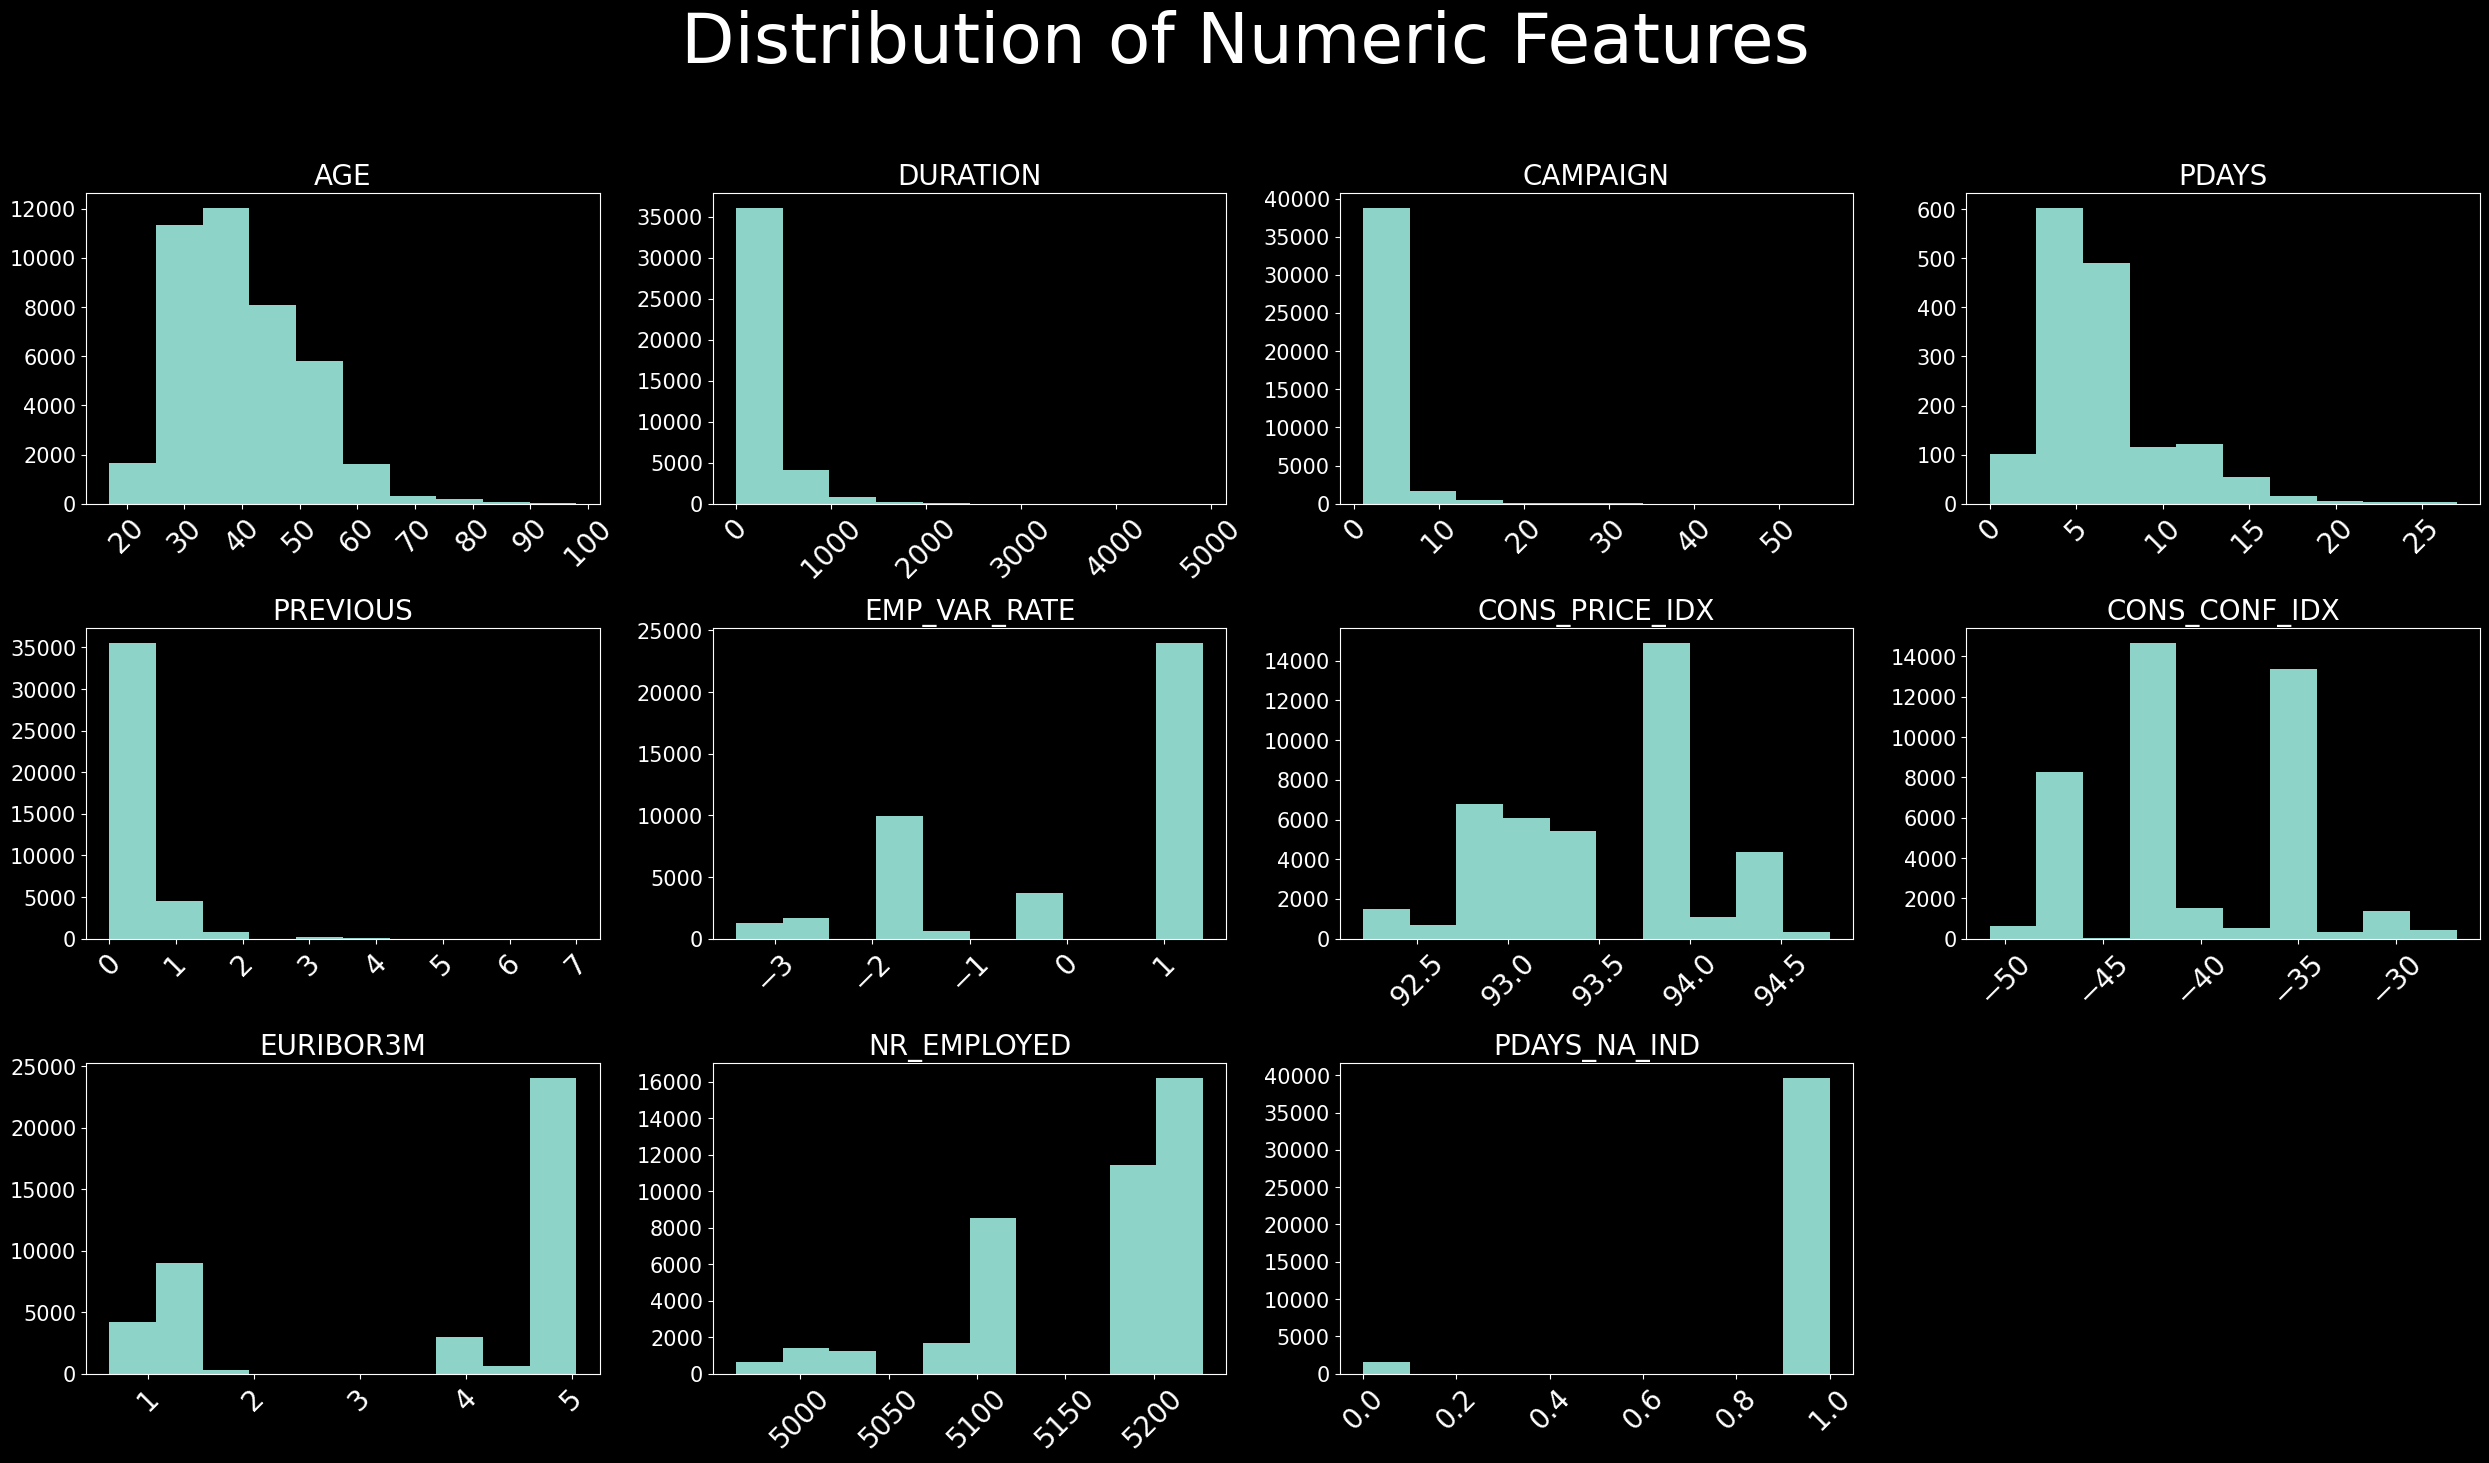

In [13]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Numeric Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df3.toPandas().describe().columns, range(1,22)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df3.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

#### Now we can see a clearer representation of the acutal values for 'pdays' as well as an estimatation of the proportion of null values for the column in our na indicator column. It's clear the vast majority of data is missing. Imputation at this level of missingness is not advisable. 

- 'age' slight right-skew with a mean of ~40 
- 'duration' is heavily right-skewed with the majority of values being below 500.
- 'campaign' another heavily right-skewed variable; most values being below 50
- 'pdays' after cleaning the distribution of the remaining data is fairly normal with a right-skew
- 'previous' another heavily right-skewed variable; most values being below 50
- 'emp_var_rate' this variable is the first with negative values, but most of the values are 1
- 'cons_price_idx' the varialbe appears bimodal with the mean appearing to be close to 93.75
- 'cons_conf_idx' this value has no clear pattern but all values are negative
- 'euribor3m' anther bimodal set with one lower group group being approx 1.25 and the other ~ 4.75 
- 'nr_employed' this distribution appears to be left skewed 
- 'pdays_na_ind' this is the null indicator column created earlier clearly outlining the large amount of missing values for pdays. 

#### Now let's get a better idea of the numeric statistics using a box an whisker plot. 


In [14]:
numeric_features = [t[0] for t in df3.dtypes if t[1] != 'string' ]
df3.select(numeric_features).summary().toPandas().set_index('summary').transpose()

summary,count,mean,stddev,min,25%,50%,75%,max
age,41188,40.02406040594348,10.421249980934043,17,32,38,47,98
duration,41188,258.2850101971448,259.27924883646455,0,102,180,319,4918
campaign,41188,2.567592502670681,2.770013542902331,1,1,2,3,56
pdays,41188,NaN,NaN,0.0,NaN,NaN,NaN,NaN
previous,41188,0.17296299893172767,0.49490107983928927,0,0,0,0,7
emp_var_rate,41188,0.08188550063178966,1.57095974051703,-3.4,-1.8,1.1,1.4,1.4
cons_price_idx,41188,93.5756643682899,0.5788400489540823,92.201,93.075,93.749,93.994,94.767
cons_conf_idx,41188,-40.502600271918276,4.628197856174573,-50.8,-42.7,-41.8,-36.4,-26.9
euribor3m,41188,3.621290812858533,1.7344474048512595,0.634,1.344,4.857,4.961,5.045
nr_employed,41188,5167.035910943957,72.25152766826338,4963.6,5099.1,5191.0,5228.1,5228.1


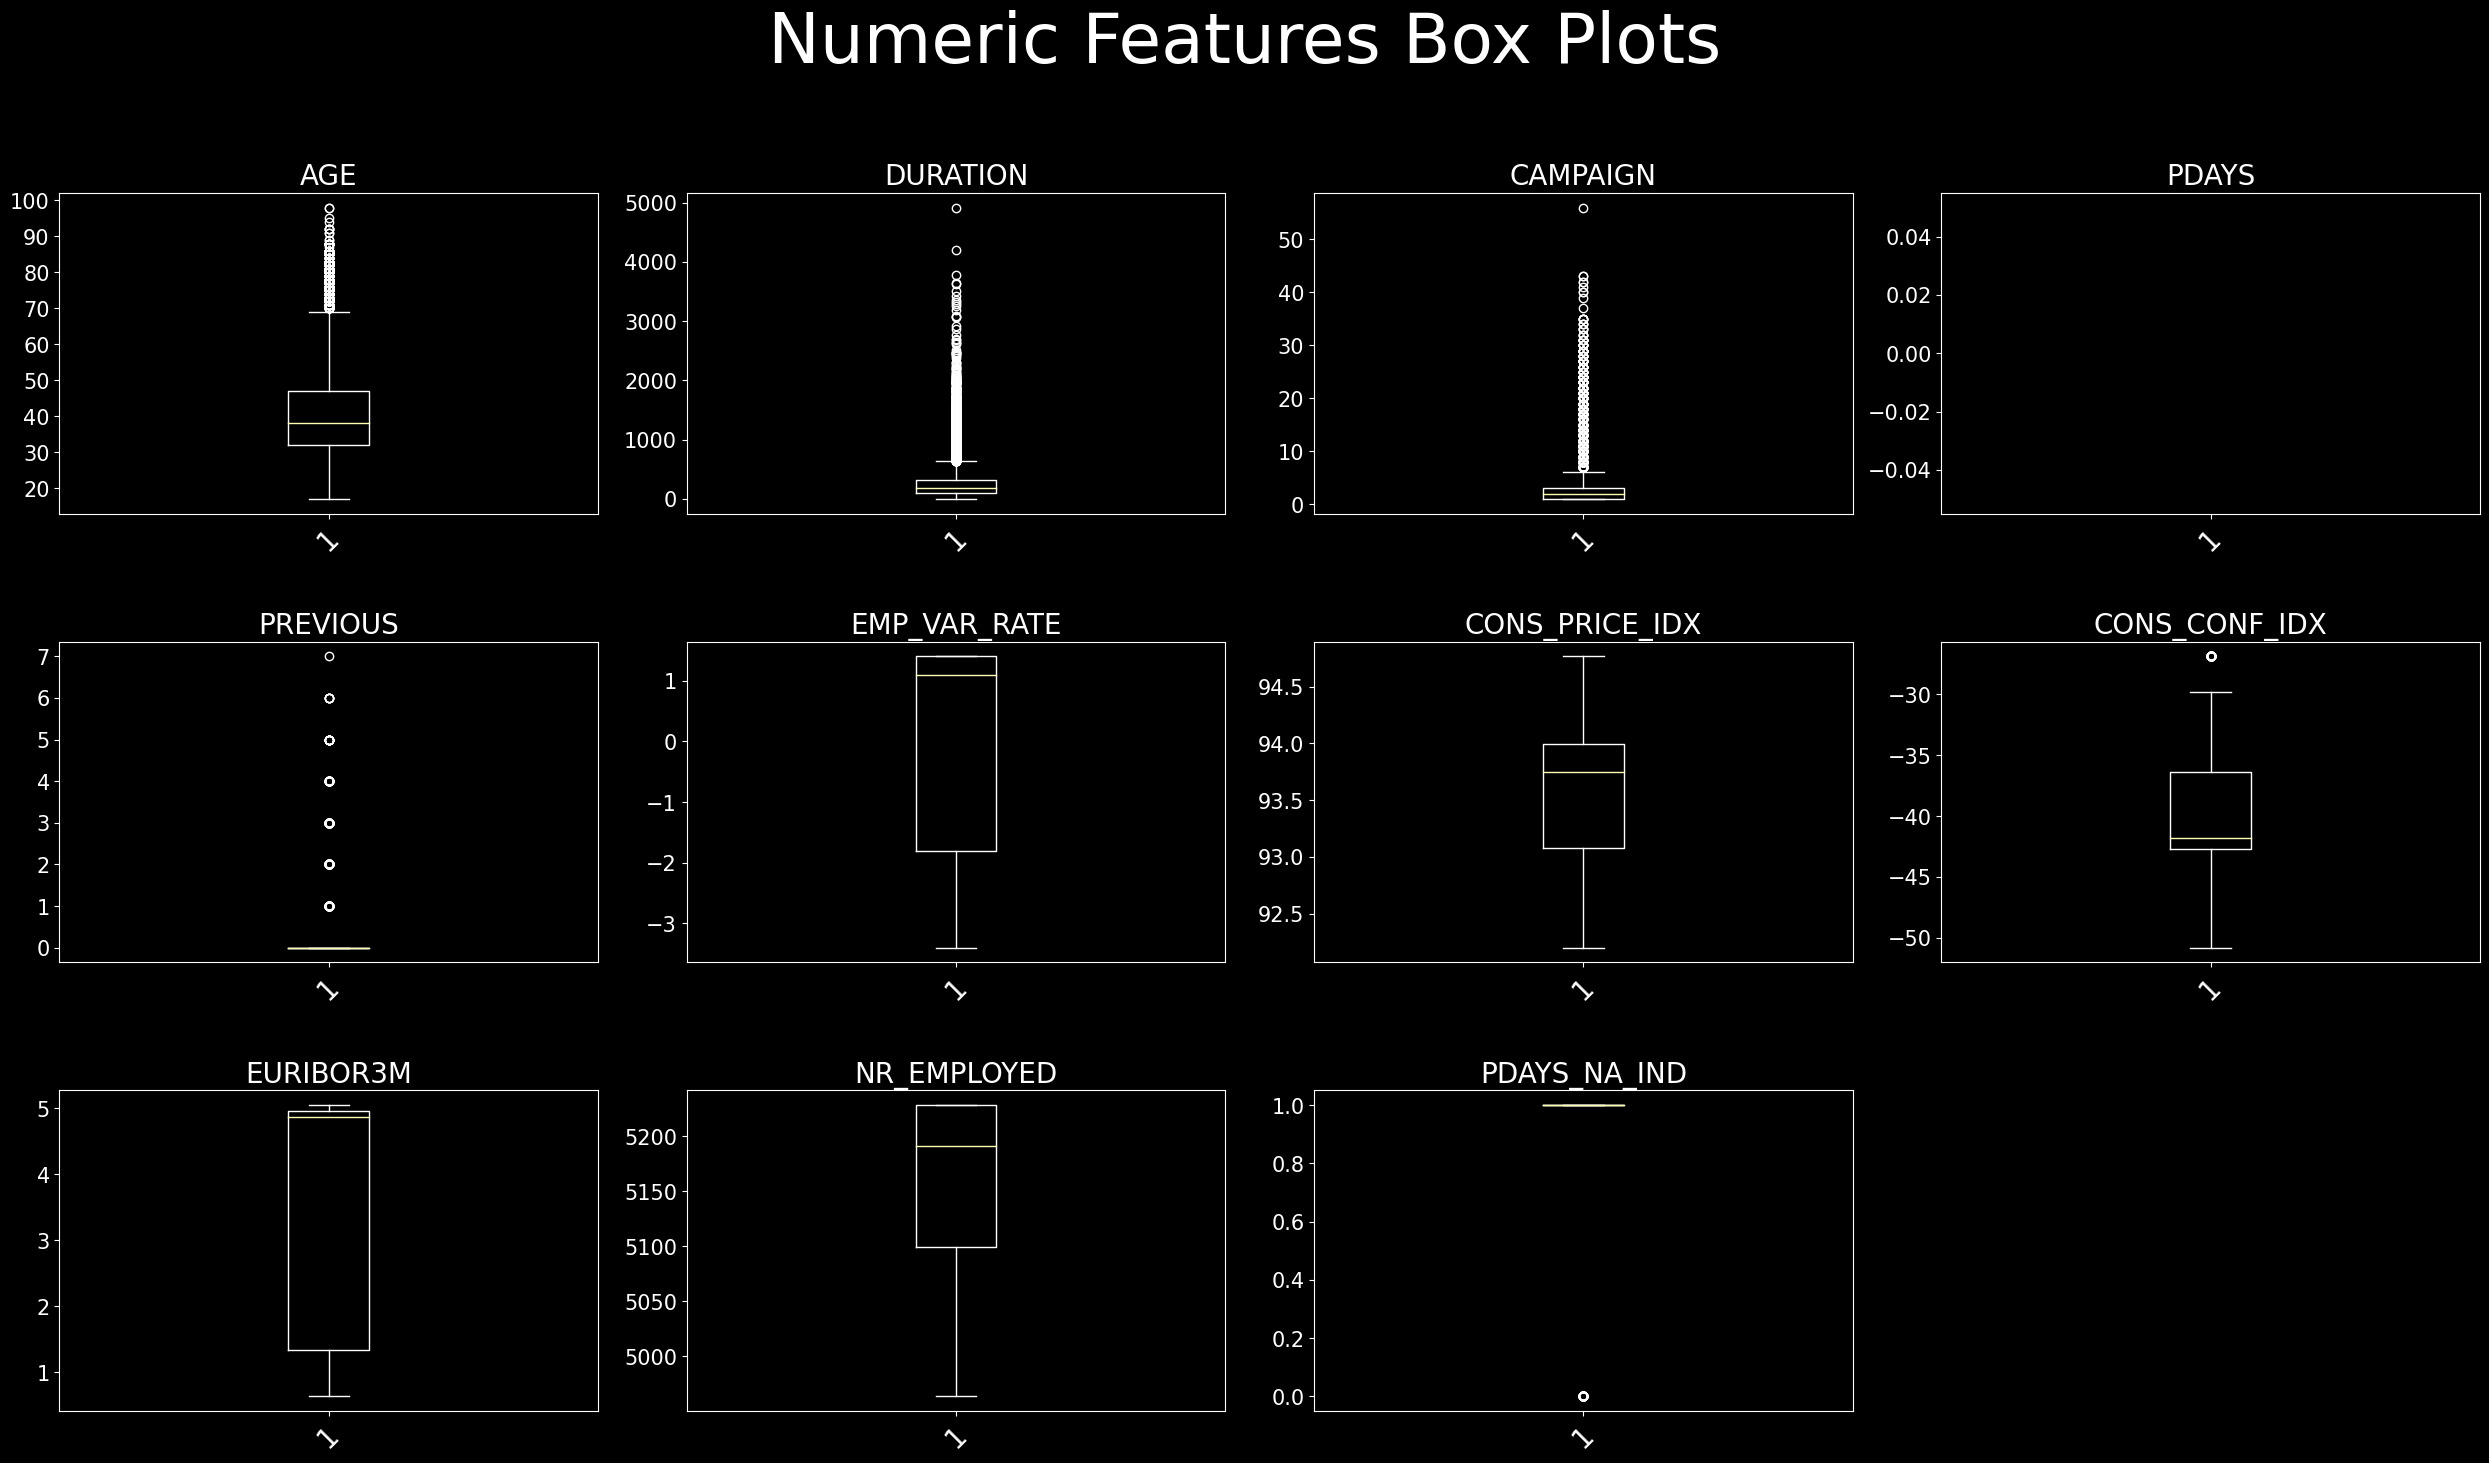

In [15]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Numeric Features Box Plots", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df3.toPandas().describe().columns, range(1,22)):
    ax = fig.add_subplot(3,4,num)
    ax.boxplot(df3.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

## Categorical Features

#### First the response variable. 

In [16]:
df3.groupby("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



#### The classes are not evenly distbuted and the class of interest is the minority class. Let's look at the rest. 

In [17]:
categorical_features = [t[0] for t in df2.dtypes if t[1] == 'string' and t[0] != 'y']

In [49]:
df3.groupby("job").count().show()
df3.groupby("marital").count().show()
df3.groupby("education").count().show()
df3.groupby("default").count().show()
df3.groupby("housing").count().show()
df3.groupby("loan").count().show()
df3.groupby("contact").count().show()
df3.groupby("month").count().show()
df3.groupby("day_of_week").count().show()
df3.groupby("poutcome").count().show()

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2924|
|      retired| 1720|
|      unknown|  330|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9254|
| entrepreneur| 1456|
|       admin.|10422|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+

+--------+-----+
| marital|count|
+--------+-----+
| unknown|   80|
|divorced| 4612|
| married|24928|
|  single|11568|
+--------+-----+

+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9515|
|            unknown| 1731|
|           basic.6y| 2292|
|professional.course| 5243|
|  university.degree|12168|
|         illiterate|   18|
|           basic.4y| 4176|
|           basic.9y| 6045|
+-------------------+-----+

+-------+-----+
|default|count|
+-------+-----+
|unknown| 8597|
|     no|32588|
|    yes|    3|
+-------+-----+

+-------+-----+
|housing|count|
+-------+-----+
|unknown|  9

#### Now we'll remove the null filler and bring back the actual nulls to get a better idea of the missing values within the set

In [ ]:
df4=df3.withColumn("marital",when(df3.marital=="unknown",np.nan).otherwise(df3.marital))\
.withColumn("education",when(df3.education=="unknown",np.nan).otherwise(df3.education))\
.withColumn("default",when(df3.default=="unknown",np.nan).otherwise(df3.default))\
.withColumn("housing",when(df3.housing=="unknown",np.nan).otherwise(df3.housing))\
.withColumn("loan",when(df3.loan=="unknown",np.nan).otherwise(df3.loan))\
.withColumn("y_int",when(df3.pdays=="no",0).otherwise(1))

In [29]:
df4 = df3.withColumn("marital_na_ind",when(df3.marital=="unknown",1).otherwise(0))\
         .withColumn("marital",when(df3.marital=="unknown",np.nan).otherwise(df3.marital))\
         .withColumn("education_na_ind",when(df3.education=="unknown",1).otherwise(0))\
         .withColumn("education",when(df3.education=="unknown",np.nan).otherwise(df3.education))\
         .withColumn("default_na_ind",when(df3.default=="unknown",1).otherwise(0))\
         .withColumn("default",when(df3.default=="unknown",np.nan).otherwise(df3.default))\
         .withColumn("housing_na_ind",when(df3.housing=="unknown",1).otherwise(0))\
         .withColumn("housing",when(df3.housing=="unknown",np.nan).otherwise(df3.housing))\
         .withColumn("load_na_ind",when(df3.loan=="unknown",1).otherwise(0))\
         .withColumn("loan",when(df3.loan=="unknown",np.nan).otherwise(df3.loan))\
         .withColumn("y_ind",when(df3.pdays=="no",0).otherwise(1))

In [51]:
from pyspark.sql.functions import col, when, count

df4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df4.columns]).toPandas().head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,euribor3m,nr_employed,y,pdays_na_ind,marital_na_ind,education_na_ind,default_na_ind,housing_na_ind,load_na_ind,y_ind
0,0,0,80,1731,8597,990,990,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
from pyspark.ml.feature import QuantileDiscretizer
#education_udf = udf(udf_multiple)
#df3.withColumn("age_group",pd.qcut(df3.age, q=5)).show(5)

qds1 = QuantileDiscretizer(inputCol="age", outputCol="age_buckets")
qds1.setNumBuckets(5)
qds1.setRelativeError(0.01)
qds1.setHandleInvalid("error")
bucketizer = qds1.fit(df2)
qds1.setHandleInvalid("keep").fit(df2).transform(df2).count()

41188

In [32]:
qds1.setHandleInvalid("skip").fit(df4).transform(df4).count()

41188

In [33]:
splits = bucketizer.getSplits()
splits

[-inf, 31.0, 35.0, 41.0, 49.0, inf]

In [34]:
df5 = qds1.setHandleInvalid("keep").fit(df4).transform(df4)

In [35]:
df5.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+------------+--------------+----------------+--------------+--------------+-----------+-----+-----------+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|pdays_na_ind|marital_na_ind|education_na_ind|default_na_ind|housing_na_ind|load_na_ind|y_ind|age_buckets|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+------------+--------------+----------------+--------------+--------------+-----------+-----+-----------+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     26

# Feature Groups

In [36]:
categorical_features = [t[0] for t in df3.dtypes if t[1] == 'string' and t[0]!='y' ]
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [56]:
numeric_features = [t[0] for t in df2.dtypes if t[1] != 'string' and t[0] != 'wasPreviouslyContacted' and t[0]!='y_ind']
numeric_features

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed']

# Correlation

## Pearson 

In [38]:
numeric_features_df=df5.select(numeric_features)

col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000866,0.004594,NaN,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,NaN,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,NaN,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
previous,0.024365,0.020640,-0.079141,NaN,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp_var_rate,-0.000371,-0.027968,0.150754,NaN,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.005312,0.127836,NaN,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,-0.008173,-0.013733,NaN,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,NaN,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,-0.044703,0.144095,NaN,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [39]:
# pick one, drop others, correlated features:
# 'housing_na_ind', 'load_na_ind' - 1.000
# 'euribor3m', 'emp_var_rate' - 0.972245
# 'euribor3m', 'nr_employed' - 0.945
# 'emp_var_rate', 'nr_employed' - 0.906970
# 'cons_price_idx', 'emp_var_rate' - 0.775334

multicollinearity_features = ('euribor3m', 'emp_var_rate','cons_price_idx', 'nr_employed', 'housing_na_ind', 'load_na_ind', "pdays")
df6 = df5.drop(*multicollinearity_features)

numeric_features = [t[0] for t in df6.dtypes if t[1] != 'string' and t[0] != 'wasPreviouslyContacted' and t[0]!='y_ind']

In [40]:
df6.select(categorical_features).show(5)

+---------+-------+-----------+-------+-------+----+---------+-----+-----------+-----------+
|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|   poutcome|
+---------+-------+-----------+-------+-------+----+---------+-----+-----------+-----------+
|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|nonexistent|
| services|married|high.school|    NaN|     no|  no|telephone|  may|        mon|nonexistent|
| services|married|high.school|     no|    yes|  no|telephone|  may|        mon|nonexistent|
|   admin.|married|   basic.6y|     no|     no|  no|telephone|  may|        mon|nonexistent|
| services|married|high.school|     no|     no| yes|telephone|  may|        mon|nonexistent|
+---------+-------+-----------+-------+-------+----+---------+-----+-----------+-----------+
only showing top 5 rows



In [46]:
#from pyspark.sql.DataFrame.dropn

df7 = df6.filter()

In [47]:
df7.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+--------+-----------+-------------+---+------------+--------------+----------------+--------------+-----+-----------+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|previous|   poutcome|cons_conf_idx|  y|pdays_na_ind|marital_na_ind|education_na_ind|default_na_ind|y_ind|age_buckets|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+--------+-----------+-------------+---+------------+--------------+----------------+--------------+-----+-----------+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|       0|nonexistent|        -36.4| no|           1|             0|               0|             0|    1|        4.0|
| 57| services|married|high.school|    NaN|     no|  no|telephone|  may|        mon|     149|       1|       0|nonexiste

In [ ]:
#null_features =  ["marital", "education", "default", "housing","loan"]
#idx_outputs =   ["marital_indexed", "education_indexed", "default_indexed", "housing_indexed","loan_indexed"]
#impute_outputs =   ["marital_imputed", "education_imputed", "default_imputed", "housing_imputed","loan_imputed"]

#stringIndexer = StringIndexer(inputCols=null_features, outputCols=idx_outputs)
#model = stringIndexer.fit(df6)
#result = model.transform(df6)

In [70]:
df2 = df2.drop('pdays')
categorical_features = [t[0] for t in df2.dtypes if t[1] == 'string' and t[0]!='y' ]
categorical_features
numeric_features = [t[0] for t in df2.dtypes if t[1] != 'string' and t[0] != 'wasPreviouslyContacted' and t[0]!='y_ind']
numeric_features

['age',
 'duration',
 'campaign',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed']

In [ ]:
# nope
imputer = Imputer(inputCols = idx_outputs,
                  outputCols = impute_outputs)
model = stringIndexer.fit(result)
imputer = model.transform(result)

In [71]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import Imputer

indexers = [
    StringIndexer(inputCol= col, outputCol="{0}_indexed".format(col))
    for col in categorical_features
]

y_indexer = [StringIndexer(inputCol= "y",
                          outputCol="label")]

encoder = OneHotEncoder(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=[
        "{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers]
)

assembler = VectorAssembler(
    inputCols=encoder.getOutputCols()+numeric_features,
    outputCol="vectorized_features"
)

scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("scaled_features")\
         #.setHandleInvalid("skip")

pipeline = Pipeline(stages=indexers + y_indexer + [encoder, assembler, scaler])
df8 = pipeline.fit(df2).transform(df2)

In [58]:
pipeline.getStages()

[StringIndexer_102c3aa30fd4,
 StringIndexer_2bfb0a7ba0dd,
 StringIndexer_0b3a8dfbcefa,
 StringIndexer_01120e5f5b7c,
 StringIndexer_3c5d928a42fd,
 StringIndexer_8066ad444706,
 StringIndexer_9b1df1475a3e,
 StringIndexer_fb8d765e4868,
 StringIndexer_375fd42abb66,
 StringIndexer_a15ab2846679,
 StringIndexer_bacc2cf33fb6,
 OneHotEncoder_5e9a800e63f7,
 VectorAssembler_bfc9226cd68e,
 StandardScaler_f7dbf57a702c]

In [72]:
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option("display.max_columns", 12)

In [74]:

df9 = df8.select(['label','scaled_features']) 
df2.write.option("header",True) \
 .csv("../data/simple_featureset")

In [75]:
train, test = df9.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


In [79]:
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7363|
|  1.0|  931|
+-----+-----+



In [77]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'scaled_features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,scaled_features,rawPrediction,prediction,probability
0,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0457...","[4.063225084942794, -4.063225084942794]",0.0,"[0.983097139802578, 0.016902860197422043]"
1,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0457...","[3.9307808945352507, -3.9307808945352507]",0.0,"[0.9807495161174413, 0.019250483882558678]"
2,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0457...","[3.573495236885482, -3.573495236885482]",0.0,"[0.9727081306506139, 0.0272918693493861]"
3,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0457...","[4.975440777593673, -4.975440777593673]",0.0,"[0.9931418840545987, 0.006858115945401311]"
4,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0457...","[3.1867865038586, -3.1867865038586]",0.0,"[0.9603339908889523, 0.03966600911104767]"


In [80]:
predictions.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  385|
|  0.0|       1.0|  197|
|  1.0|       0.0|  546|
|  0.0|       0.0| 7166|
+-----+----------+-----+



In [81]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 385  546]
 [ 197 7166]]


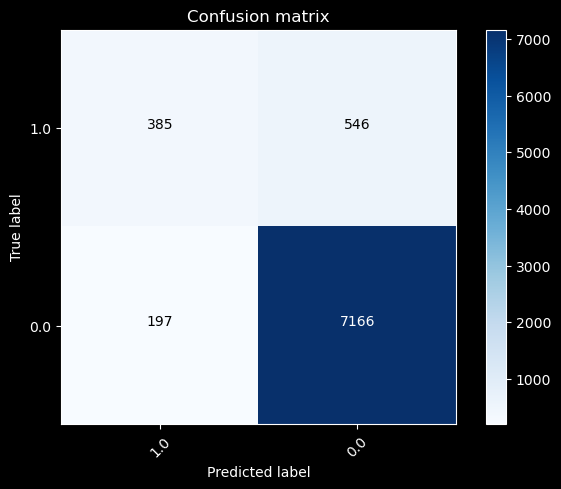

In [82]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [83]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9104171690378587


In [84]:
# in the earlier example
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

objectiveHistory:
0.35223916681289025
0.2776820677451751
0.2535629567569434
0.22324054909886942
0.21562116908050205
0.21218382217733378


In [88]:
print("Labels: " + str(trainingSummary.labels))
print("Accuracy: " + str(trainingSummary.accuracy))
print("False Positives By Label: " + str(trainingSummary.falsePositiveRateByLabel))
print("Precision By Label: " + str(trainingSummary.precisionByLabel))
print("Recall By Label: " + str(trainingSummary.recallByLabel))
print("Weighted False Positive Rate: " + str(trainingSummary.weightedFalsePositiveRate))

Labels: [0.0, 1.0]
Accuracy: 0.9092843679698426
False Positives By Label: [0.6117551900781882, 0.024498886414253896]
Precision By Label: [0.9261849767396467, 0.6682134570765661]
Recall By Label: [0.9755011135857461, 0.3882448099218118]
Weighted False Positive Rate: 0.5455384444622845


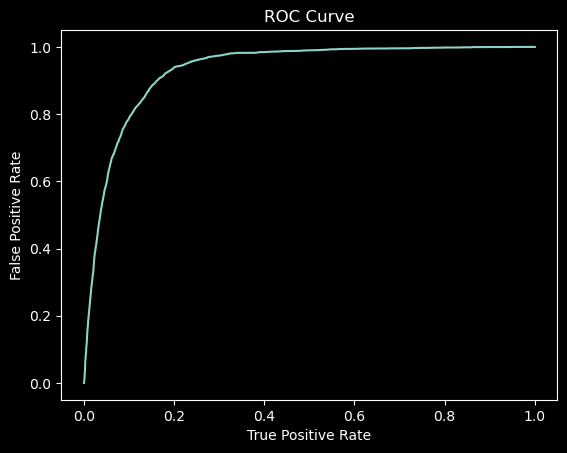

Training set areaUnderROC: 0.9320642023280693


In [89]:

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [93]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])# regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])# Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [1, 5, 10])#Number of iterations
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)

In [94]:
## Evaluate Best Model
cv_predictions = cvModel.transform(test)
print('Best Model Test Area Under ROC', evaluator.evaluate(cv_predictions))

Best Model Test Area Under ROC 0.9353638894387751


In [95]:
cvModel.bestModel

LogisticRegressionModel: uid=LogisticRegression_b25e681710ee, numClasses=2, numFeatures=52

In [96]:
weights = cvModel.bestModel.coefficients
weights = [(float(w),) for w in weights]
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
weightsDF.toPandas().head(10)

,Feature Weight
0,0.003079
1,-0.049596
2,0.000000
3,0.000000
4,0.000000
5,0.050256
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [98]:
best_model=cvModel.bestModel
best_model.explainParams().split("\n")

['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)',
 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.5)',
 'family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)',
 'featuresCol: features column name. (default: features, current: scaled_features)',
 'fitIntercept: whether to fit an intercept term. (default: True)',
 'labelCol: label column name. (default: label, current: label)',
 'lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)',
 'lowerBoundsOnIntercepts: The lower bounds on intercepts i

Confusion matrix, without normalization
[[ 292  639]
 [ 172 7191]]


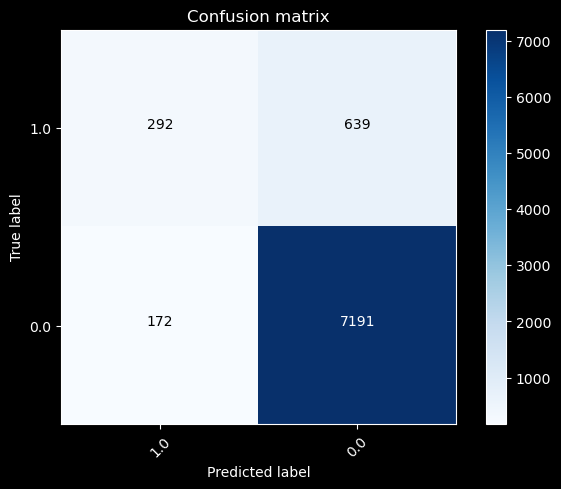

In [100]:
y_true = cv_predictions.select("label")
y_true = y_true.toPandas()

y_pred = cv_predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [101]:
trainingSummary_cv = best_model.summary
print("Labels: " + str(trainingSummary_cv.labels))
print("Accuracy: " + str(trainingSummary_cv.accuracy))
print("False Positives By Label: " + str(trainingSummary_cv.falsePositiveRateByLabel))
print("Precision By Label: " + str(trainingSummary_cv.precisionByLabel))
print("Recall By Label: " + str(trainingSummary_cv.recallByLabel))
print("Weighted False Positive Rate: " + str(trainingSummary_cv.weightedFalsePositiveRate))

Labels: [0.0, 1.0]
Accuracy: 0.9042682556089257
False Positives By Label: [0.6934483688325694, 0.01977043001541888]
Precision By Label: [0.9175112251443233, 0.6633605600933489]
Recall By Label: [0.9802295699845811, 0.30655163116743056]
Weighted False Positive Rate: 0.617487054456914


In [90]:
y_true = predictions2.select("label")
y_true = y_true.toPandas()

y_pred = predictions2.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

NameError: name 'predictions2' is not defined

In [ ]:
df7.select('label').show(5)

In [39]:
df8 = df7.select(['label','scaled_features']) 
df8.show(5)

+-----+--------------------+
|label|     scaled_features|
+-----+--------------------+
|  0.0|(53,[8,11,18,21,2...|
|  0.0|(53,[3,11,15,22,2...|
|  0.0|(53,[3,11,15,21,2...|
|  0.0|(53,[0,11,19,21,2...|
|  0.0|(53,[3,11,15,21,2...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col, asc, desc

major_df = df8.filter(col('label') == 0.0)
minor_df = df8.filter(col("label") == 1.0)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

In [ ]:
a = range(ratio)

In [ ]:
from pyspark.sql.functions import col, explode, array, lit
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

In [ ]:
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)

In [ ]:
train_over, test_over = combined_df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

In [ ]:
train.groupBy('label').count().show()

In [ ]:
train_over.groupBy('label').count().show()

In [ ]:
train_over.show(5)

In [ ]:
lr2 = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'label', maxIter=5)

lrModel2 = lr2.fit(train_over)

predictions2 = lrModel2.transform(test)

#predictions_train = lrModel.transform(train)
predictions2.select('label', 'scaled_features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

In [ ]:
predictions2.groupBy('label','prediction').count().show()

In [ ]:
# in the earlier example
trainingSummary = lrModel2.summary
trainingSummary.falsePositiveRateByLabel

In [ ]:
trainingSummary.weightedFalsePositiveRate

In [ ]:
trainingSummary.recallByLabel

In [ ]:
y_true = predictions2.select("label")
y_true = y_true.toPandas()

y_pred = predictions2.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [ ]:
predictions3 = lrModel2.transform(test)

In [ ]:
y_true = predictions3.select("label")
y_true = y_true.toPandas()

y_pred = predictions3.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [36]:
class Struct(object):
    def __init__(self, *args):
        self.__header__ = str(args[0]) if args else None

    def __repr__(self):
        if self.__header__ is None:
             return super(Struct, self).__repr__()
        return self.__header__

    def next(self):
        """ Fake iteration functionality.
        """
        raise StopIteration

    def __iter__(self):
        """ Fake iteration functionality.
        We skip magic attribues and Structs, and return the rest.
        """
        ks = self.__dict__.keys()
        for k in ks:
            if not k.startswith('__') and not isinstance(k, Struct):
                yield getattr(self, k)

    def __len__(self):
        """ Don't count magic attributes or Structs.
        """
        ks = self.__dict__.keys()
        return len([k for k in ks if not k.startswith('__')\
                    and not isinstance(k, Struct)])

conf = Struct("smote_config")
conf.seed = 48
conf.bucketLength = 100
conf.k = 4
conf.multiplier = 3

In [37]:
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer

def smote(vectorized_sdf,smote_config):
    '''
    contains logic to perform smote oversampling, given a spark df with 2 classes
    inputs:
    * vectorized_sdf: cat cols are already stringindexed, num cols are assembled into 'features' vector
      df target col should be 'label'
    * smote_config: config obj containing smote parameters
    output:
    * oversampled_df: spark df after smote oversampling
    '''
    dataInput_min = vectorized_sdf[vectorized_sdf['label'] == 1]
    dataInput_maj = vectorized_sdf[vectorized_sdf['label'] == 0]
    
    # LSH, bucketed random projection
    brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes",seed=smote_config.seed, bucketLength=smote_config.bucketLength)
    # smote only applies on existing minority instances    
    model = brp.fit(dataInput_min)
    model.transform(dataInput_min)

    # here distance is calculated from brp's param inputCol
    self_join_w_distance = model.approxSimilarityJoin(dataInput_min, dataInput_min, float("inf"), distCol="EuclideanDistance")

    # remove self-comparison (distance 0)
    self_join_w_distance = self_join_w_distance.filter(self_join_w_distance.EuclideanDistance > 0)

    over_original_rows = Window.partitionBy("datasetA").orderBy("EuclideanDistance")

    self_similarity_df = self_join_w_distance.withColumn("r_num", F.row_number().over(over_original_rows))

    self_similarity_df_selected = self_similarity_df.filter(self_similarity_df.r_num <= smote_config.k)

    over_original_rows_no_order = Window.partitionBy('datasetA')

    # list to store batches of synthetic data
    res = []
    
    # two udf for vector add and subtract, subtraction include a random factor [0,1]
    subtract_vector_udf = F.udf(lambda arr: random.uniform(0, 1)*(arr[0]-arr[1]), VectorUDT())
    add_vector_udf = F.udf(lambda arr: arr[0]+arr[1], VectorUDT())
    
    # retain original columns
    original_cols = dataInput_min.columns
    
    for i in range(smote_config.multiplier):
        print("generating batch %s of synthetic instances"%i)
        # logic to randomly select neighbour: pick the largest random number generated row as the neighbour
        df_random_sel = self_similarity_df_selected.withColumn("rand", F.rand()).withColumn('max_rand', F.max('rand').over(over_original_rows_no_order))\
                            .where(F.col('rand') == F.col('max_rand')).drop(*['max_rand','rand','r_num'])
        # create synthetic feature numerical part
        df_vec_diff = df_random_sel.select('*', subtract_vector_udf(F.array('datasetA.features', 'datasetB.features')).alias('vec_diff'))
        df_vec_modified = df_vec_diff.select('*', add_vector_udf(F.array('datasetA.features', 'vec_diff')).alias('features'))
        
        # for categorical cols, either pick original or the neighbour's cat values
        for c in original_cols:
            # randomly select neighbour or original data
            col_sub = random.choice(['datasetA','datasetB'])
            val = "{0}.{1}".format(col_sub,c)
            if c != 'features':
                # do not unpack original numerical features
                df_vec_modified = df_vec_modified.withColumn(c,F.col(val))
        
        # this df_vec_modified is the synthetic minority instances,
        df_vec_modified = df_vec_modified.drop(*['datasetA','datasetB','vec_diff','EuclideanDistance'])
        
        res.append(df_vec_modified)
    
    dfunion = reduce(DataFrame.unionAll, res)
    # union synthetic instances with original full (both minority and majority) df
    oversampled_df = dfunion.union(vectorized_sdf.select(dfunion.columns))
    
    return oversampled_df

In [40]:
df9 = df8.withColumnRenamed('scaled_features', 'features')
df9.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(53,[8,11,18,21,2...|
|  0.0|(53,[3,11,15,22,2...|
|  0.0|(53,[3,11,15,21,2...|
|  0.0|(53,[0,11,19,21,2...|
|  0.0|(53,[3,11,15,21,2...|
+-----+--------------------+
only showing top 5 rows



In [41]:

import random
from functools import reduce
from pyspark.sql.window import Window
from pyspark.sql import Row, DataFrame
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.feature import StandardScaler, ChiSqSelector, StringIndexer, VectorAssembler, BucketedRandomProjectionLSH, VectorSlicer

smoted_train_df = smote(df9,conf)

generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances


In [44]:
def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    return udf(to_array_, ArrayType(DoubleType())).asNondeterministic()(col)

def restore_smoted_df(num_cols,smoted_df,vectorized_col):
    '''
    restore smoted df to original type
    with original num_cols names
    and stringIndexed cat cols, suffix _index
    depending on to_array udf to unpack vectorized col
    * vectorized_col: str, col that is vectorized
    '''
    # based on the assumption that vectorization is by the list sequence of num_cols
    # to array first
    smoted_df = smoted_df.withColumn("array_num_cols", to_array(col(vectorized_col)))
    # restore all num_cols
    for i in range(len(num_cols)):
        smoted_df = smoted_df.withColumn(num_cols[i], col("array_num_cols")[i])

    drop_cols = [vectorized_col,'array_num_cols']
    return smoted_df.drop(*drop_cols)

In [ ]:
lrModel.save("../models/lrModel1")